# Eurovision 2022 (Draft Notebook)

## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper

In [1]:
import pandas as pd
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [2]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0.1,Unnamed: 0,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [3]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "weight"
}, inplace=True)

In [30]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]
df_finals_jury

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,weight,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

In [5]:
fig = px.histogram(df_2022_ukraine)
fig.show()

NameError: name 'df_2022_ukraine' is not defined

In [6]:
fig = px.histogram(df_2014_ukraine)
fig.show()

NameError: name 'df_2014_ukraine' is not defined

In [7]:
fig = px.histogram(df_2016_ukraine)
fig.show()

NameError: name 'df_2016_ukraine' is not defined

# Network of votes

In [8]:
df_finals_televoting_2022 = df_finals_televoting[df_finals_televoting["Year"]==2022]

display(df_finals_televoting_2022)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,weight,Duplicate
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


#### A Sample of the Null Model

In [46]:
import numpy as np

df_finals_televoting_2022_AT = df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Austria"].copy()

df_finals_televoting_2022_AT["fit"] = np.random.uniform(0, 1, size=len(df_finals_televoting_2022_AT))
df_finals_televoting_2022_AT["p_vc"] = 58 * (df_finals_televoting_2022_AT["fit"]/sum(df_finals_televoting_2022_AT["fit"]))

df_finals_televoting_2022_AT

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,weight,Duplicate,fit,p_vc
54533,54533,54533,2022,f,2022f,T,Austria,Armenia,0,NaN,0.600423,3.200529
54534,54534,54534,2022,f,2022f,T,Austria,Australia,0,NaN,0.075826,0.404189
54535,54535,54535,2022,f,2022f,T,Austria,Azerbaijan,0,NaN,0.452024,2.409494
54536,54536,54536,2022,f,2022f,T,Austria,Belgium,0,NaN,0.705524,3.760765
54537,54537,54537,2022,f,2022f,T,Austria,Czech Republic,0,NaN,0.153005,0.815589
54538,54538,54538,2022,f,2022f,T,Austria,Estonia,0,NaN,0.216179,1.152331
54539,54539,54539,2022,f,2022f,T,Austria,Finland,0,NaN,0.475309,2.533612
54540,54540,54540,2022,f,2022f,T,Austria,France,0,NaN,0.596354,3.178840
54541,54541,54541,2022,f,2022f,T,Austria,Germany,2,NaN,0.154237,0.822151
54542,54542,54542,2022,f,2022f,T,Austria,Greece,0,NaN,0.043614,0.232482


#### A sample Model1

In [98]:
# TODO: Rules have changed in 2022?

SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

df_finals_televoting_2022_AT = df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Austria"].copy()

df_finals_televoting_2022_AT["fit"] = np.random.uniform(0, 1, size=len(df_finals_televoting_2022_AT))
df_finals_televoting_2022_AT["rank"] = df_finals_televoting_2022_AT["fit"].rank(ascending=False)
df_finals_televoting_2022_AT["p_vc"] = df_finals_televoting_2022_AT["rank"].apply(
    lambda x: SCORES[int(x - 1)] if x <= 10 else 0
)


df_finals_televoting_2022_AT

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,weight,Duplicate,fit,rank,p_vc
54533,54533,54533,2022,f,2022f,T,Austria,Armenia,0,NaN,0.102134,21.0,0
54534,54534,54534,2022,f,2022f,T,Austria,Australia,0,NaN,0.333586,16.0,0
54535,54535,54535,2022,f,2022f,T,Austria,Azerbaijan,0,NaN,0.245897,19.0,0
54536,54536,54536,2022,f,2022f,T,Austria,Belgium,0,NaN,0.608087,8.0,3
54537,54537,54537,2022,f,2022f,T,Austria,Czech Republic,0,NaN,0.645288,6.0,5
54538,54538,54538,2022,f,2022f,T,Austria,Estonia,0,NaN,0.793503,4.0,7
54539,54539,54539,2022,f,2022f,T,Austria,Finland,0,NaN,0.516529,9.0,2
54540,54540,54540,2022,f,2022f,T,Austria,France,0,NaN,0.705847,5.0,6
54541,54541,54541,2022,f,2022f,T,Austria,Germany,2,NaN,0.243578,20.0,0
54542,54542,54542,2022,f,2022f,T,Austria,Greece,0,NaN,0.622515,7.0,4


#### Affinity Model

In [99]:
# TODO: Rules have changed in 2022?

SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

df_finals_televoting_2022_AT = df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Austria"].copy()

df_finals_televoting_2022_AT["fit"] = np.random.uniform(0, 1, size=len(df_finals_televoting_2022_AT))





df_finals_televoting_2022_AT["rank"] = df_finals_televoting_2022_AT["fit"].rank(ascending=False)
df_finals_televoting_2022_AT["p_vc"] = df_finals_televoting_2022_AT["rank"].apply(
    lambda x: SCORES[int(x - 1)] if x <= 10 else 0
)


df_finals_televoting_2022_AT

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,weight,Duplicate,fit,rank,p_vc
54533,54533,54533,2022,f,2022f,T,Austria,Armenia,0,NaN,0.557153,16.0,0
54534,54534,54534,2022,f,2022f,T,Austria,Australia,0,NaN,0.672717,13.0,0
54535,54535,54535,2022,f,2022f,T,Austria,Azerbaijan,0,NaN,0.100713,24.0,0
54536,54536,54536,2022,f,2022f,T,Austria,Belgium,0,NaN,0.556469,17.0,0
54537,54537,54537,2022,f,2022f,T,Austria,Czech Republic,0,NaN,0.499734,20.0,0
54538,54538,54538,2022,f,2022f,T,Austria,Estonia,0,NaN,0.246687,23.0,0
54539,54539,54539,2022,f,2022f,T,Austria,Finland,0,NaN,0.857734,4.0,7
54540,54540,54540,2022,f,2022f,T,Austria,France,0,NaN,0.998398,1.0,12
54541,54541,54541,2022,f,2022f,T,Austria,Germany,2,NaN,0.842446,6.0,5
54542,54542,54542,2022,f,2022f,T,Austria,Greece,0,NaN,0.558109,15.0,0


In [100]:
#weighted_edges = df_finals_televoting_2022.loc[:, ["From country","To country", "Points"]].to_records(index=False)
#voting_graph.add_weighted_edges_from(list(weighted_edges))
voting_graph = nx.from_pandas_edgelist(
    df_finals_televoting_2022,
    source="from",
    target="to",
    edge_attr=["weight"],
    create_using=nx.DiGraph()
)

#weighted_edges = df_finals_televoting_2022.loc[:, [,"To country", "Points"]].to_records(index=False)


In [115]:
display(voting_graph.get_edge_data("United Kingdom", "Ukraine"))
display(voting_graph.get_edge_data("Ukraine", "United Kingdom"))

{'weight': 12}

{'weight': 7}

In [101]:
voting_graph.number_of_nodes()

40

In [102]:
voting_graph.number_of_edges()

975

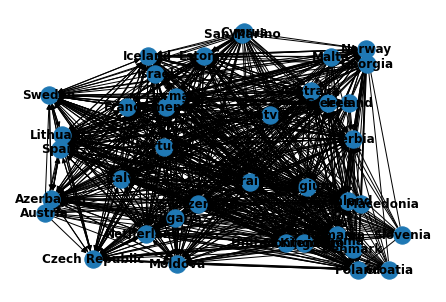

In [12]:
nx.draw_random(voting_graph, with_labels=True, font_weight='bold')

In [27]:
nt = pyvisnetwork.Network(height='1000px', width='1000px', directed=True, notebook=True)
# populates the nodes and edges data structures
nt.show_buttons()
nt.from_nx(voting_graph)
nt.show('nx.html')

In [23]:
import bokeh
from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx

G = nx.karate_club_graph()

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="", toolbar_location=None)

graph = from_networkx(voting_graph, nx.random_layout, center=(0,0))
plot.renderers.append(graph)

bokeh.io.output_notebook()
show(plot)

Loading BokehJS ...

# Agent Based Modelling

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [112]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (ISO Country Codes)
        '''
        
        super().__init__(unique_id, model, df)
        
        voting_countries = df["from"].unique()
        competing_countries = df["to"].unique()
        
        df["fit"] = self.random.uniform(0, 1, size=len(df))
        
        for competing_country in competing_countries:
            fit_competing_country = df[df["to"] == competing_country]["fit"]
            points = 58 * (fit_competing_country)/sum(df["fit"])
            
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [ ]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (ISO Country Codes)
        '''
        
        super().__init__(unique_id, model)
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [ ]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (ISO Country Codes)
        '''
        
        super().__init__(unique_id, model)
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


## Adding space

Let’s add a simple spatial element to our model by putting our agents on a grid.

Mesa has a special type of a grid called NetworkGrid, where agents can be placed in custom network constalation you can create.

`from mesa.space import NetworkGrid`

We instantiate a network grid with networkx package, specifically `nx.barabasi_albert_graph`, which takes parameters n and m. 
It returns a random graph using Barabási–Albert preferential attachment. 
Under the hood, a graph of nodes is grown by attaching new nodes each with edges that are preferentially attached to existing nodes with high degree.

**Note: If you are interested in using *Vertex copy model* from the lectures, please use `nx.gnc_graph(n)`, which obviously takes only the parameter n - total number of nodes in the model.**

**Note: If you would like to update the network graph (for example in the step function of your Agent or Model - in your projects) you would have to use the methods `model.G.add_node()` and `model.G.add_edge()`, and make sure you apply the attachement algorithm manually yourself. But this reasoning is probably out of scope for this course, since most of the behavior of such interconnected nodes in the graph can be explored with a generated graph.**


In [122]:
class NullVotingModel(Model):
    
    def __init__(self, df):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        
        
        #self.datacollector = DataCollector(
        #    agent_reporters={"m": "m"}
        #)
        
        for voting_country in self.voting_countries:
            a = NullVotingAgent(i, self, df)
            #self.grid.place_agent(a, i)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        pass

# 2. Run the Agent/Model Basic

### Running the model

At this point, we have a model which runs. 
You can see for yourself with a few easy lines. If you’ve been working in an jupyter notebook session, you can create a model object directly. 

With that last piece in hand, it’s time for the first rudimentary run of the model.

Now let’s create a model with 100 agents
There is no need to run the model, since there are no steps to run.

In [123]:
model = ScaleFreeModel(100, 5)

# 3. Visualize the Network

Let's visualize a small Barabasi-Albert network graph with an average node degree parameter 5 (as used in the original paper - Barabási and Albert (1999)

In [124]:
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

def network_portrayal(G):
# The model ensures there is always 1 agent per node

    betweenness_centrality = dict(nx.betweenness_centrality(G))
    
    def node_color(agent, n_id):
        #return '#008000'
        return "rgba("+ str(betweenness_centrality[n_id] * 10 * 256) +",128,128,1.0)"
    
    def edge_color(agent1, agent2):
        return '#e8e8e8'
    
    def edge_width(agent1, agent2):
        return 2
    
    portrayal = dict()
    
    portrayal['nodes'] = [{'id': n_id,
                        'agent_id': n['agent'][0].unique_id,
                        'size': 2,
                        'color': node_color(n['agent'][0], n_id),
                        }
                        for n_id, n in G.nodes(data=True)]
    
    portrayal['edges'] = [{'id': i,
                        'source': source,
                        'target': target,
                        'color': edge_color(G.nodes[source]['agent'][0], G.nodes[target]['agent'][0]),
                        'width': edge_width(G.nodes[source]['agent'][0], G.nodes[target]['agent'][0]),
                        }
                        for i, (source, target, _) in enumerate(G.edges(data=True))]
    
    return portrayal

network = NetworkModule(network_portrayal, 800, 800, library='d3')
chart = ChartModule([{'Label': 'Agent', 'Color': '#008000'}])

class Density(TextElement):
    def render(self, model):
        Density = nx.density(model.G)
        return 'Density: ' + str(Density)

text = Density()

model_params = {
    'N': UserSettableParameter('slider', 'Number of agents', 10, 10, 1000, 10,
    description='Choose how many agents to include in the model'),
    'm': UserSettableParameter('slider', 'Avg Node Degree', 3, 3, 5, 1,
    description='Avg Node Degree'),
    }

server = ModularServer(ScaleFreeModel, [network, chart, text], 'Barabasi-Albert Model', model_params)

# 4. Run the Network Visualization

NOTE: Runtime server error is normal and expected when running visualization code below. This visualization code was made for command line execution (not explicitly for Jupyter Notebooks), so we are **forcing** it's use.

Just make sure to increment the port number counter each visualization run, to be able to use it.

In [125]:
server.port = 8524 # The default 8521 - increase the counter as you run the visalizations
server.launch() # Uncomment to run the visalization

Interface starting at http://127.0.0.1:8524


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

# 5. Collect data to Analyze the Network

In [7]:
print('Number of agents {}'.format(model.G.number_of_nodes()))
print('Number of edges {}'.format(model.G.number_of_edges()))
print('Number of edges {}'.format(nx.info(model.G)))

print('Density {}'.format(nx.density(model.G)))
print('Number of selfloop edges {}'.format(nx.number_of_selfloops(model.G)))
print('Frequency of each degree value {}'.format(nx.degree_histogram(model.G))) # The degree values are the index in the list.

Number of agents 100
Number of edges 475
Number of edges Graph with 100 nodes and 475 edges
Density 0.09595959595959595
Number of selfloop edges 0
Frequency of each degree value [0, 0, 0, 0, 0, 23, 26, 11, 8, 2, 4, 2, 6, 2, 3, 2, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]


<ipython-input-7-ccf91687e3d3>:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print('Number of edges {}'.format(nx.info(model.G)))


# 6. Run the Agent/Model Analysis

## Question 1

1.1 Plot a graph of degrees for all nodes in the network model.

1.2 As network grows by a step (one node), explain the growth behavior that you observe on the plot?

1.3 For the last-added node, retrieve its neighbours and plot a histogram of the degrees of those neighbours.

1.4 Where and why did that new node attach itself to?

(array([ 0.,  0.,  0.,  0.,  0., 23., 26., 11.,  8.,  2.,  4.,  2.,  6.,
         2.,  3.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,

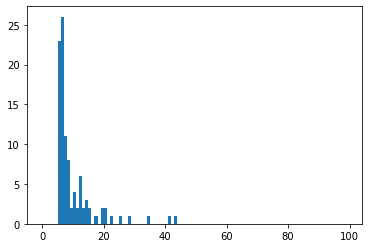

In [8]:
# Answer 1.1 [Your code here]
import matplotlib.pyplot as plt

degree_per_node = dict(model.G.degree(model.G))

plt.hist( list(degree_per_node.values()), list(degree_per_node.keys()) )

degree_per_neighbour={11: 20, 19: 19, 45: 8, 90: 6, 94: 6}


<AxesSubplot:>

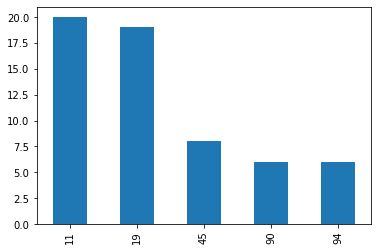

In [12]:
# Answer 1.3 [Your code here]
import pandas as pd

last_node_index = model.G.number_of_nodes() - 1
degree_per_neighbour = dict(model.G.degree(list(nx.neighbors(model.G, last_node_index))))

degree_per_neighbour = dict(sorted(degree_per_neighbour.items()))
print(f"{degree_per_neighbour=}")


data = pd.Series(degree_per_neighbour)

data.plot.bar()

## Answer 1.2 and 1.4

_1.2 As network grows by a step (one node), explain the growth behavior that you observe on the plot?_
Follows power law and preferntial attachment concept


_1.4 Where and why did that new node attach itself to?_
It will connect it to 5 neighbours.  It will choose nodes based on their degrees.  These happen to be early nodes with high degrees.

## Question 2

2.1 Plot the log log degree distribution for the network with 10k nodes.

2.2 Explain the graph?

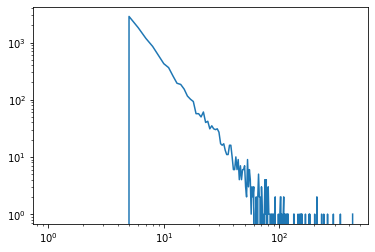

In [17]:
# Answer 2.1 [Your code here]
model_10k = ScaleFreeModel(10000, 5)

hist_10k = nx.degree_histogram(model_10k.G)

plt.loglog( range(0, len(hist_10k)), hist_10k )





## Answer 2.2

This is also following a power law.  The vast majority of nodes have a small degree.  The number of nodes with very high degrees is indeed very small and can barely be seen towards teh right of the x-axis

## Question 3

3.1 Investigate a number of degree distribution for the newtork in a few timesteps (t=10k, t=100k, t=1Million) and plot the log log degree distribution for those three networks.

3.3 Do you observe a stable degree distribution for the network regardless of its size?

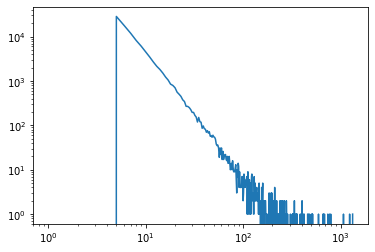

In [18]:
# Answer 3.1 [Your code here]
model_100K = ScaleFreeModel(100000, 5)

hist_100K = nx.degree_histogram(model_100K.G)
plt.loglog( range(0, len(hist_100K)), hist_100K )

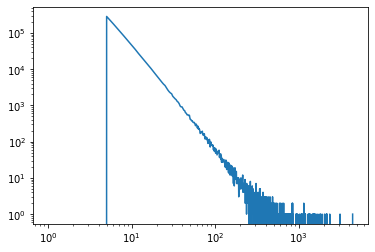

In [19]:
model_1M = ScaleFreeModel(1000000, 5)

hist_1M = nx.degree_histogram(model_1M.G)
plt.loglog( range(0, len(hist_1M)), hist_1M )

## Answer 3.3

Yes, whether the network is 10K, 100K or 1M nodes, we always see this powerlaw based degree distribution.  This makes this a "scale-free network"

# References


Spijkervet/eurovision-dataset

@misc{spijkervet_eurovision,
    author       = {Janne Spijkervet},
    title        = {{The Eurovision Dataset}},
    month        = mar,
    year         = 2020,
    doi          = {10.5281/zenodo.4036457},
    version      = {1.0},
    publisher    = {Zenodo},
    url          = {https://zenodo.org/badge/latestdoi/214236225}
}